In [1]:
import pandas as pd
import os
import subprocess
import zipfile
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pylab 
import scipy.stats as st
import pymc3  as pm
import seaborn as sns
import arviz as az
from sklearn.preprocessing import scale
from matplotlib import rcParams
from scipy import interpolate
import matplotlib.cm as cm


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
wave = np.array([412,443,488,531,547,555,667,678])
λ = np.array([412, 443, 469, 488, 531, 547, 555, 645, 667, 678], dtype=np.int32)


In [239]:
ndata = len(wave)
Lt_names = ['Lt_%d' % wv for wv in wave]
Lr_names = ['Lr_%d' % wv for wv in wave]
La_names = ['La_%d' % wv for wv in wave]
TLg_names = ['TLg_%d' % wv for wv in wave]
tLf_names = ['tLf_%d' % wv for wv in wave]
polcor_names = ['polcor_%d' % wv for wv in wave]
brdf_names = ['brdf_%d' % wv for wv in wave]
Rrs_mob_names = ['Rrs_mob_%d' % wv for wv in wave]
Rrs_aqua_names = ['Rrs_aqua_%d' % wv for wv in wave]

chl_names = ['chlor_a_%d' % wv for wv in wave]
relaz_names = ['relaz_%d' % wv for wv in wave]
scat_names = ['scattang_%d' % wv for wv in wave]
glint_names = ['glint_coef_%d' % wv for wv in wave]

Lw_names = ['Lw_%d' % wv for wv in wave]
tg_sol_names = ['tg_sol_%d' % wv for wv in wave]
tg_sen_names = ['tg_sen_%d' % wv for wv in wave]
aot_names = ['aot_%d' % wv for wv in wave]

tsol_names = ['t_sol_%d' % wv for wv in wave]
tsen_names = ['t_sen_%d' % wv for wv in wave]
water_vapor_names = ['water_vapor_%d' % wv for wv in wave]
solz_names = ['solz_%d' % wv for wv in wave]
senz_names = ['senz_%d' % wv for wv in wave]
angstrom_names = ['angstrom_%d' % wv for wv in wave]
epsilon_names = ['epsilon_%d' % wv for wv in wave]
windspeed_names = ['windspeed_%d' % wv for wv in wave]
humidity_names = ['humidity_%d' % wv for wv in wave]
pressure_names = ['pressure_%d' % wv for wv in wave]
ozone_names = ['ozone_%d' % wv for wv in wave]
rhot_names = ['rhot_%d' % wv for wv in wave]

In [341]:
df = np.load('moby_df', allow_pickle=True)

In [345]:
ndf = df.dropna()
# ndf[Lt_names] = np.atleast_2d(fsol.values).T*ndf[Lt_names]
# ndf[Lr_names] = np.atleast_2d(fsol.values).T*ndf[Lr_names]
# ndf[La_names] = np.atleast_2d(fsol.values).T*ndf[La_names]
# ndf[TLg_names] = np.atleast_2d(fsol.values).T*ndf[TLg_names]
# ndf[tLf_names] = np.atleast_2d(fsol.values).T*ndf[tLf_names]

airmass = 1/np.cos(np.deg2rad(ndf[solz_names])).values + 1/np.cos(np.deg2rad(ndf[senz_names])).values
ndf[water_vapor_names] = airmass*ndf[water_vapor_names]
ndf[ozone_names] = airmass*ndf[ozone_names]

dfn = (ndf - ndf.mean())/ndf.std()


/accounts/aibrahi2/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [346]:
indx = np.arange(0,len(wave))

with pm.Model() as pooled_model_ST_MLR:
    hyp_α_sd = pm.HalfCauchy('hyp_α_sd', 1)
    hyp_β_sd = pm.HalfCauchy('hyp_β_sd', 1)
    
    # Independent parameters for each county
    α = pm.Normal('α', 0, sd=hyp_α_sd, shape=ndata)
    β0 = pm.Normal('β0', 0, sd=hyp_β_sd, shape=ndata)
    β1 = pm.Normal('β1', 0, sd=hyp_β_sd, shape=ndata)
    β2 = pm.Normal('β2', 0, sd=hyp_β_sd, shape=ndata)
    β3 = pm.Normal('β3', 0, sd=hyp_β_sd, shape=ndata)
    β4 = pm.Normal('β4', 0, sd=hyp_β_sd, shape=ndata)
    β5 = pm.Normal('β5', 0, sd=hyp_β_sd, shape=ndata)
    
    # Model DOF
    ν = pm.Exponential('ν', 1/30)

    # Model error
    σ = pm.HalfCauchy('σ', 1)
    
#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[brdf_names]  +\
#                β2[indx]*dfn[windspeed_names] + β3[indx]*dfn[glint_names]
    
#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[solz_names]  +\
#                β2[indx]*dfn[senz_names] + β3[indx]*dfn[relaz_names]
    
    Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[windspeed_names]  +\
               β2[indx]*dfn[water_vapor_names] + β3[indx]*dfn[humidity_names] +\
               β4[indx]*dfn[pressure_names] + β5[indx]*dfn[ozone_names]

#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[angstrom_names]  +\
#                β2[indx]*dfn[epsilon_names] + β3[indx]*dfn[aot_names]+ β4[indx]*dfn[polcor_names]

#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[Lr_names]  +\
#                β2[indx]*dfn[La_names] + β3[indx]*dfn[tLf_names]+ β4[indx]*dfn[TLg_names]

#     Rrs_est = α[indx] + β0[indx]*dfn[Rrs_mob_names] + β1[indx]*dfn[tsol_names]  +\
#                β2[indx]*dfn[tsen_names] + β3[indx]*dfn[tg_sol_names]+ β4[indx]*dfn[tg_sen_names]


    # Data likelihood
    likelihood = pm.StudentT('Rrs_est', mu=Rrs_est, sd=σ, nu=ν, observed=dfn[Rrs_aqua_names])
    
with pooled_model_ST_MLR:
    trace_hc_mlr = pm.sample(2000,tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ν, β5, β4, β3, β2, β1, β0, α, hyp_β_sd, hyp_α_sd]
Sampling 4 chains, 70 divergences: 100%|██████████| 20000/20000 [00:42<00:00, 475.38draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6955579179903824, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


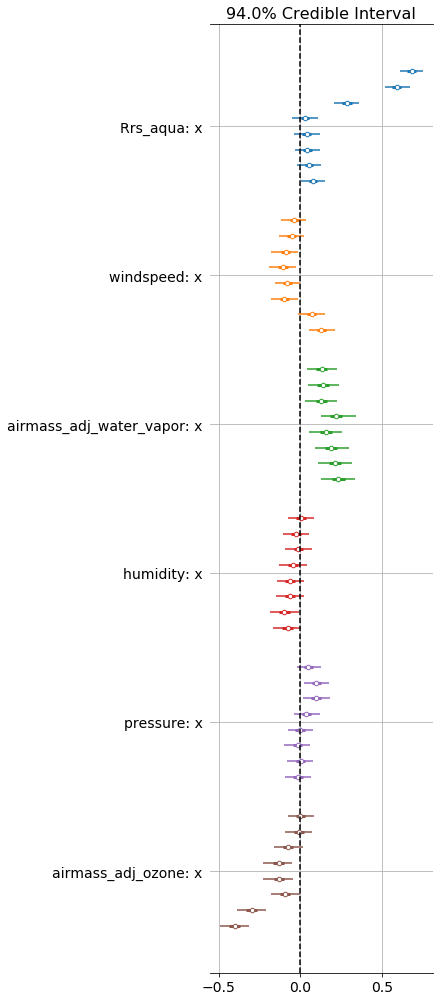

In [348]:
# mnames =  [ 'Rrs_aqua','brdf', 'windspeed', 'glint_coeff']
# mnames =  ['Rrs_aqua','solz', 'senz', 'relaz']
mnames =  ['Rrs_aqua','windspeed', 'airmass_adj_water_vapor', 'humidity', 'pressure', 'airmass_adj_ozone']
# mnames =  ['Rrs_aqua','angstrom', 'epsilon', 'aot', 'polcor']
# mnames =  ['Rrs_aqua','Lr', 'La', 'tLf', 'TLg']
# mnames =  ['Rrs_aqua','tsol', 'tsen', 'Tgsol', 'Tgsen']


ax = az.plot_forest([np.flipud(trace_hc_mlr['β0'].T), np.flipud(trace_hc_mlr['β1'].T),
               np.flipud(trace_hc_mlr['β2'].T), np.flipud(trace_hc_mlr['β3'].T)
                ,np.flipud(trace_hc_mlr['β4'].T), 
                     np.flipud(trace_hc_mlr['β5'].T)    
                    ], 
               model_names=mnames)

# az.plot_forest([np.flipud(trace_hc_mlr['β0'].T), ], model_names=[ 'glint',])
ax[0].axvline(0, color='k', ls='--');
ax[0].grid()
# plt.savefig('forest_plot_at_surface_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_geom_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_ancillary_data_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_aerosol_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_radiances_aqua.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('forest_plot_transmittances.pdf', dpi=300, bbox_inches='tight')

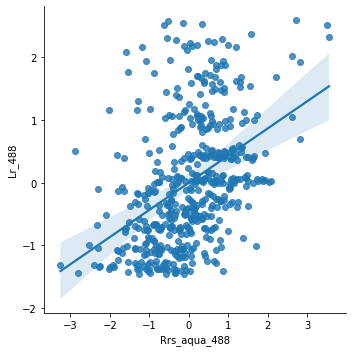

In [59]:
sns.lmplot('Rrs_aqua_488', 'Lr_488', dfn, ci=100)
# plt.xlim([0,0.01])

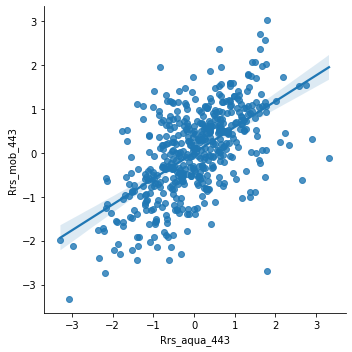

In [19]:
sns.lmplot('Rrs_aqua_443', 'Rrs_mob_443', dfn, ci=95)

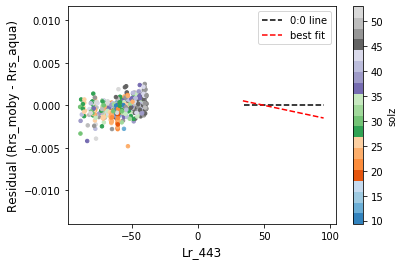

In [324]:
l= 443
y = ndf['Rrs_diff_' + np.str(l)]
x = ndf['Lr_' + np.str(l)].values
z = ndf['solz_' + np.str(l)]

cm = plt.cm.get_cmap('tab20c')
sc = plt.scatter(x, y, c=z, vmin=z.min(), vmax=z.max(), s=12, cmap=cm)
scb = plt.colorbar(sc, label='solz')

plt.ylabel('Residual (Rrs_moby - Rrs_aqua)', fontsize=12)
plt.xlabel('Lr_' + np.str(l), fontsize=12)
plt.plot([35,95], [0,0], '--k', label= '0:0 line')
plt.plot(xx,yy, '--r', label= 'best fit')
# plt.xlim([35,95])
plt.legend()
# plt.savefig('Residual_Lr_443.pdf', dpi=300,  bbox_inches='tight')


In [203]:
from scipy import stats

In [210]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [231]:
xx = np.linspace(34,95, 100)
yy = intercept + slope*xx

In [310]:
F0 = np.array([1729.12    , 1876.22    , 2058.78    , 1949.33    , 1857.47    ,
       1865.39    , 1838.6901  , 1578.1101  , 1522.55    , 1480.52    ,
       1280.65    ,  971.74005 ,  958.24    ,  454.66998 ,  239.76999 ,
         98.850006], dtype=np.float32)
λ = np.array([412, 443, 469, 488, 531, 547, 555, 645, 667, 678], dtype=np.int32)
F0i = interpolate.interp1d(λ, F0[:10])(wave).T


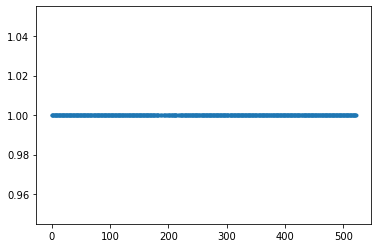

In [319]:
rhot_0 = (np.pi*(np.atleast_2d(ndf['Lt_412'].values)).T/\
        (np.atleast_2d(F0i).T[0]* np.atleast_2d(np.cos(np.deg2rad(ndf['solz_412']))).T))[:,0]

plt.plot(ndf['rhot_412']/ rhot_0, '.');

In [297]:
fsol  = ndf['rhot_412']/ rhot_0

In [307]:
np.atleast_2d(fsol.values).T*dfn[Lt_names]

,Lt_412,Lt_443,Lt_488,Lt_531,Lt_547,Lt_555,Lt_667,Lt_678
0,0.723430,0.577953,0.419920,0.221917,0.150811,0.143654,-0.191111,-0.215764
1,0.491120,0.443309,0.489691,0.570020,0.626815,0.642634,1.037558,1.067205
2,0.495457,0.435803,0.474950,0.531002,0.575229,0.626212,0.896307,0.918379
3,1.503292,1.415373,1.339847,1.235854,1.172196,1.150748,0.605399,0.553577
4,0.047035,0.093357,0.380703,0.750079,0.908937,0.971977,2.209869,2.312905
...,...,...,...,...,...,...,...,...
518,-0.260742,-0.230663,-0.200856,-0.163234,-0.121705,-0.133770,0.232450,0.265625
519,0.423725,0.334792,0.145547,-0.086737,-0.163734,-0.199357,-0.709452,-0.750594
520,-0.233663,-0.128825,0.074285,0.339627,0.476718,0.505076,1.510675,1.598797
521,0.979314,0.900951,0.742267,0.527178,0.442736,0.407505,-0.180486,-0.236723


In [306]:
fsol.values.shape

(500,)

In [320]:
fsol

0      1.033427
1      1.032020
2      1.022248
3      1.012275
4      1.011573
         ...   
518    0.992354
519    0.992836
520    0.996399
521    0.997378
522    0.997946
Name: rhot_412, Length: 500, dtype: float64

,senz_412,senz_443,senz_488,senz_531,senz_547,senz_555,senz_667,senz_678
0,1.180862,1.180862,1.180862,1.180862,1.180862,1.180862,1.180862,1.180862
1,1.068795,1.068795,1.068795,1.068795,1.068795,1.068795,1.068795,1.068795
2,1.061378,1.061378,1.061378,1.061378,1.061378,1.061378,1.061378,1.061378
3,1.540993,1.540993,1.540993,1.540993,1.540993,1.540993,1.540993,1.540993
4,1.562231,1.562231,1.562231,1.562231,1.562231,1.562231,1.562231,1.562231
...,...,...,...,...,...,...,...,...
518,1.546715,1.546715,1.546715,1.546715,1.546715,1.546715,1.546715,1.546715
519,1.185176,1.185176,1.185176,1.185176,1.185176,1.185176,1.185176,1.185176
520,1.339741,1.339741,1.339741,1.339741,1.339741,1.339741,1.339741,1.339741
521,1.351369,1.351369,1.351369,1.351369,1.351369,1.351369,1.351369,1.351369


In [338]:
airmass =  1/np.cos(np.deg2rad(ndf[solz_names])).values + 1/np.cos(np.deg2rad(ndf[senz_names])).values


In [339]:
ndf[water_vapor_names] = airmass*ndf[water_vapor_names]


/accounts/aibrahi2/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [343]:
ndf[water_vapor_names] 

,water_vapor_412,water_vapor_443,water_vapor_488,water_vapor_531,water_vapor_547,water_vapor_555,water_vapor_667,water_vapor_678
0,3.383029,3.383029,3.383029,3.383029,3.383029,3.383029,3.383029,3.383029
1,2.623265,2.623265,2.623265,2.623265,2.623265,2.623265,2.623265,2.623265
2,3.329041,3.329041,3.329041,3.329041,3.329041,3.329041,3.329041,3.329041
3,2.573214,2.573214,2.573214,2.573214,2.573214,2.573214,2.573214,2.573214
4,3.094143,3.094143,3.094143,3.094143,3.094143,3.094143,3.094143,3.094143
...,...,...,...,...,...,...,...,...
518,2.391980,2.391980,2.391980,2.391980,2.391980,2.391980,2.391980,2.391980
519,2.691465,2.691465,2.691465,2.691465,2.691465,2.691465,2.691465,2.691465
520,2.821936,2.821936,2.821936,2.821936,2.821936,2.821936,2.821936,2.821936
521,2.785033,2.785033,2.785033,2.785033,2.785033,2.785033,2.785033,2.785033
